<a href="https://colab.research.google.com/github/yousenwang/DeepCOOH/blob/master/KerasCOOH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import io
import requests

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_url = "https://github.com/yousenwang/DeepCOOH/blob/master/labeled_train_data_imputed_KNNImputer(add_indicator-False%20copy-True%20metric-nan_euclidean%20missing_values-nan%20n_neighbors-5%20weights-distance).csv?raw=true"
test_url = "https://raw.githubusercontent.com/yousenwang/DeepCOOH/master/labeled_test_data_imputed_KNNImputer(add_indicator-False%20copy-True%20metric-nan_euclidean%20missing_values-nan%20n_neighbors-5%20weights-distance).csv"
s = requests.get(train_url).content
train = pd.read_csv(io.StringIO(s.decode("big5")))

s_test = requests.get(train_url).content
test = pd.read_csv(io.StringIO(s.decode("big5")))

In [22]:
train.head()

,Capacity_14,R5_AGI_OP_14,R5_AGI_AMP_14,R5_VACCUM_PRESSURE_14,R5_IN_LEVEL_14,R5_OUT_LEVEL_14,R5_IN_TEMP_14,R5_OUT_TEMP_14,R5_DELETA_TEMP_14,CPF_IN_PRESSURE_14,CPF_OUT_PRESSURE_14,R5_DELETA_PRESSURE_14,R5_IV_14,Capacity_15,R5_AGI_OP_15,R5_AGI_AMP_15,R5_VACCUM_PRESSURE_15,R5_IN_LEVEL_15,R5_OUT_LEVEL_15,R5_IN_TEMP_15,R5_OUT_TEMP_15,R5_DELETA_TEMP_15,CPF_IN_PRESSURE_15,CPF_OUT_PRESSURE_15,R5_DELETA_PRESSURE_15,R5_IV_15,z_Capacity_SUM,z_Capacity_DIFF,R1_TEMP,R1_HEATING_TEMP,R1_LEVEL,R1_PRESSURE,R1_REFLUX_RATIO,R2_TEMP,R2_LEVEL,R2_REFLUX_RATIO,SB_PPM,COA_PPM,R4_LEVEL,R4_TEMP,...,FRC05_14_OP,TI05_27_PV,TR05_13_PV,TI05_17_PV,TI05_09_PV,LRC06_05P_PV,LRC06_05P_SP,LRC06_05P_OP,LRC06_05_PV,PRC06_03A_PV,TRC06_06_PV,TRC06_06_SP,TRC06_06_OP,LRC06_13_SP,LRC06_13_OP,T1_PASTE_TIME,T2_R1_TIME,MR,9-1115,9-1109A,9-1109B,9-1112P,R2COOH,R4COOH,R5PCOOH_14,R5PIV_14,ColorL_14,ColorA_14,ColorB_14,9-1112F,R5PCOOH_15,R5PIV_15,ColorL_15,ColorA_15,ColorB_15,Z_R1_LEVEL_MW,Z_R1_LEVEL_RT,Z_PASTE_LEVEL_MW,Z_PASTE_LEVEL_RT,R1COOH
0,275.0,82.8,91.044512,1.350853,3.805199,1.814777,279.407684,282.646027,3.238342,32.221768,14.321963,17.910102,0.555816,275.0,86.3,88.378360,1.302064,1.786692,4.332234,278.693451,281.484283,2.790833,55.327758,39.309939,16.0,0.558741,550.0,26.752009,264.110718,322.209648,74.690687,0.879577,4.3,265.579680,58.265210,4.3,190.0,100.0,39.470198,284.501251,...,39.494234,63.840485,177.473969,33.432129,172.421448,19.781980,20.0,52.225609,12.000925,130.077926,276.516770,276.5,53.522928,40.0,62.0,111.555239,157.625707,1.080000,2.102048,18.976940,2.995514,1.588136,529.799754,115.752971,53.800000,0.557117,62.9,-0.100000,-1.0,1.641733,53.700000,0.550718,64.3,-0.039957,-1.4,58911.613,154.24132,42701.390,111.800000,1218.0
1,275.0,90.0,86.422228,1.239932,3.180051,3.446612,279.429962,282.467255,3.037292,31.609870,14.440012,17.176444,0.547751,275.0,89.6,87.518289,1.282108,1.268468,3.986628,278.693451,281.640656,2.947205,55.459392,39.344522,16.0,0.554759,550.0,25.892505,263.244629,321.629800,75.128933,0.880566,4.3,265.554301,57.634976,4.3,190.0,100.0,39.394390,284.501251,...,39.123073,62.421814,177.538788,34.631531,171.817413,19.847824,20.0,53.849977,12.601181,129.965223,276.484369,276.5,50.263333,40.0,60.2,111.564357,158.312602,1.100000,2.112646,18.958764,3.038586,1.579999,472.372757,112.600000,53.000000,0.557387,62.6,0.100000,-1.1,1.637335,52.800000,0.548594,65.0,-0.036663,-1.2,59191.105,154.97308,42693.395,111.779070,1262.0
2,275.0,90.6,86.575325,1.195895,2.762419,1.946913,279.429962,282.668365,3.238403,32.063108,14.412657,17.680026,0.554541,275.0,90.6,86.719611,1.252102,0.411792,3.494172,278.671173,281.551300,2.880127,54.123116,38.563619,16.0,0.550119,550.0,26.567633,263.466675,322.082240,74.192675,0.880263,4.3,265.655582,57.404790,4.3,190.0,95.0,38.048402,284.523590,...,39.992168,61.712738,177.473969,33.597534,172.356720,20.658709,20.0,56.490265,12.355534,130.079756,276.441560,276.5,51.684608,40.0,60.5,111.977957,156.856088,1.099924,1.958756,19.365182,2.430038,1.714896,500.600010,115.646152,45.795183,0.557195,61.7,-0.020642,-1.0,1.702587,45.264529,0.550530,64.8,0.100000,-1.0,58595.605,153.41396,42865.555,112.229810,1273.0
3,275.0,89.0,86.299786,1.202386,4.118613,2.496231,279.363007,282.377899,3.014893,32.526139,14.546016,17.967812,0.549987,275.0,89.0,86.553951,1.294007,0.574108,2.071295,278.648834,281.528961,2.880127,56.354630,40.065867,16.0,0.554463,550.0,25.943551,263.222412,321.106710,74.005544,0.878412,4.3,265.449207,57.871304,4.3,190.0,95.0,39.705921,284.523590,...,38.978663,63.256226,177.582031,33.142700,172.335175,20.787714,20.0,53.006891,12.367957,129.988170,276.506477,276.5,53.021911,40.0,59.5,112.414786,156.555730,1.070000,1.993329,19.079921,2.556929,1.707598,517.199816,115.751689,45.365779,0.556776,63.2,-0.100000,-0.9,1.689166,44.762772,0.555584,63.2,-0.096073,-0.9,58477.300,153.10420,43040.000,112.686550,1219.0
4,275.0,89.5,85.595597,1.100851,3.251318,2.480879,279.318390,282.199188,2.880798,33.314811,14.827635,18.489673,0.559214,275.0,91.0

In [24]:
test.head()

,Capacity_14,R5_AGI_OP_14,R5_AGI_AMP_14,R5_VACCUM_PRESSURE_14,R5_IN_LEVEL_14,R5_OUT_LEVEL_14,R5_IN_TEMP_14,R5_OUT_TEMP_14,R5_DELETA_TEMP_14,CPF_IN_PRESSURE_14,CPF_OUT_PRESSURE_14,R5_DELETA_PRESSURE_14,R5_IV_14,Capacity_15,R5_AGI_OP_15,R5_AGI_AMP_15,R5_VACCUM_PRESSURE_15,R5_IN_LEVEL_15,R5_OUT_LEVEL_15,R5_IN_TEMP_15,R5_OUT_TEMP_15,R5_DELETA_TEMP_15,CPF_IN_PRESSURE_15,CPF_OUT_PRESSURE_15,R5_DELETA_PRESSURE_15,R5_IV_15,z_Capacity_SUM,z_Capacity_DIFF,R1_TEMP,R1_HEATING_TEMP,R1_LEVEL,R1_PRESSURE,R1_REFLUX_RATIO,R2_TEMP,R2_LEVEL,R2_REFLUX_RATIO,SB_PPM,COA_PPM,R4_LEVEL,R4_TEMP,...,FRC05_14_OP,TI05_27_PV,TR05_13_PV,TI05_17_PV,TI05_09_PV,LRC06_05P_PV,LRC06_05P_SP,LRC06_05P_OP,LRC06_05_PV,PRC06_03A_PV,TRC06_06_PV,TRC06_06_SP,TRC06_06_OP,LRC06_13_SP,LRC06_13_OP,T1_PASTE_TIME,T2_R1_TIME,MR,9-1115,9-1109A,9-1109B,9-1112P,R2COOH,R4COOH,R5PCOOH_14,R5PIV_14,ColorL_14,ColorA_14,ColorB_14,9-1112F,R5PCOOH_15,R5PIV_15,ColorL_15,ColorA_15,ColorB_15,Z_R1_LEVEL_MW,Z_R1_LEVEL_RT,Z_PASTE_LEVEL_MW,Z_PASTE_LEVEL_RT,R1COOH
0,275.0,82.8,91.044512,1.350853,3.805199,1.814777,279.407684,282.646027,3.238342,32.221768,14.321963,17.910102,0.555816,275.0,86.3,88.378360,1.302064,1.786692,4.332234,278.693451,281.484283,2.790833,55.327758,39.309939,16.0,0.558741,550.0,26.752009,264.110718,322.209648,74.690687,0.879577,4.3,265.579680,58.265210,4.3,190.0,100.0,39.470198,284.501251,...,39.494234,63.840485,177.473969,33.432129,172.421448,19.781980,20.0,52.225609,12.000925,130.077926,276.516770,276.5,53.522928,40.0,62.0,111.555239,157.625707,1.080000,2.102048,18.976940,2.995514,1.588136,529.799754,115.752971,53.800000,0.557117,62.9,-0.100000,-1.0,1.641733,53.700000,0.550718,64.3,-0.039957,-1.4,58911.613,154.24132,42701.390,111.800000,1218.0
1,275.0,90.0,86.422228,1.239932,3.180051,3.446612,279.429962,282.467255,3.037292,31.609870,14.440012,17.176444,0.547751,275.0,89.6,87.518289,1.282108,1.268468,3.986628,278.693451,281.640656,2.947205,55.459392,39.344522,16.0,0.554759,550.0,25.892505,263.244629,321.629800,75.128933,0.880566,4.3,265.554301,57.634976,4.3,190.0,100.0,39.394390,284.501251,...,39.123073,62.421814,177.538788,34.631531,171.817413,19.847824,20.0,53.849977,12.601181,129.965223,276.484369,276.5,50.263333,40.0,60.2,111.564357,158.312602,1.100000,2.112646,18.958764,3.038586,1.579999,472.372757,112.600000,53.000000,0.557387,62.6,0.100000,-1.1,1.637335,52.800000,0.548594,65.0,-0.036663,-1.2,59191.105,154.97308,42693.395,111.779070,1262.0
2,275.0,90.6,86.575325,1.195895,2.762419,1.946913,279.429962,282.668365,3.238403,32.063108,14.412657,17.680026,0.554541,275.0,90.6,86.719611,1.252102,0.411792,3.494172,278.671173,281.551300,2.880127,54.123116,38.563619,16.0,0.550119,550.0,26.567633,263.466675,322.082240,74.192675,0.880263,4.3,265.655582,57.404790,4.3,190.0,95.0,38.048402,284.523590,...,39.992168,61.712738,177.473969,33.597534,172.356720,20.658709,20.0,56.490265,12.355534,130.079756,276.441560,276.5,51.684608,40.0,60.5,111.977957,156.856088,1.099924,1.958756,19.365182,2.430038,1.714896,500.600010,115.646152,45.795183,0.557195,61.7,-0.020642,-1.0,1.702587,45.264529,0.550530,64.8,0.100000,-1.0,58595.605,153.41396,42865.555,112.229810,1273.0
3,275.0,89.0,86.299786,1.202386,4.118613,2.496231,279.363007,282.377899,3.014893,32.526139,14.546016,17.967812,0.549987,275.0,89.0,86.553951,1.294007,0.574108,2.071295,278.648834,281.528961,2.880127,56.354630,40.065867,16.0,0.554463,550.0,25.943551,263.222412,321.106710,74.005544,0.878412,4.3,265.449207,57.871304,4.3,190.0,95.0,39.705921,284.523590,...,38.978663,63.256226,177.582031,33.142700,172.335175,20.787714,20.0,53.006891,12.367957,129.988170,276.506477,276.5,53.021911,40.0,59.5,112.414786,156.555730,1.070000,1.993329,19.079921,2.556929,1.707598,517.199816,115.751689,45.365779,0.556776,63.2,-0.100000,-0.9,1.689166,44.762772,0.555584,63.2,-0.096073,-0.9,58477.300,153.10420,43040.000,112.686550,1219.0
4,275.0,89.5,85.595597,1.100851,3.251318,2.480879,279.318390,282.199188,2.880798,33.314811,14.827635,18.489673,0.559214,275.0,91.0

In [4]:
features = "Capacity_15	R2_TEMP	R5PIV_14	R2_REFLUX_RATIO	ColorB_14	R5_DELETA_PRESSURE_15	R2_LEVEL	R4_AGI_OP	R5PCOOH_14	ColorB_15	CPF_OUT_PRESSURE_15	CPF_IN_PRESSURE_14".split("\t")
len(features)

12

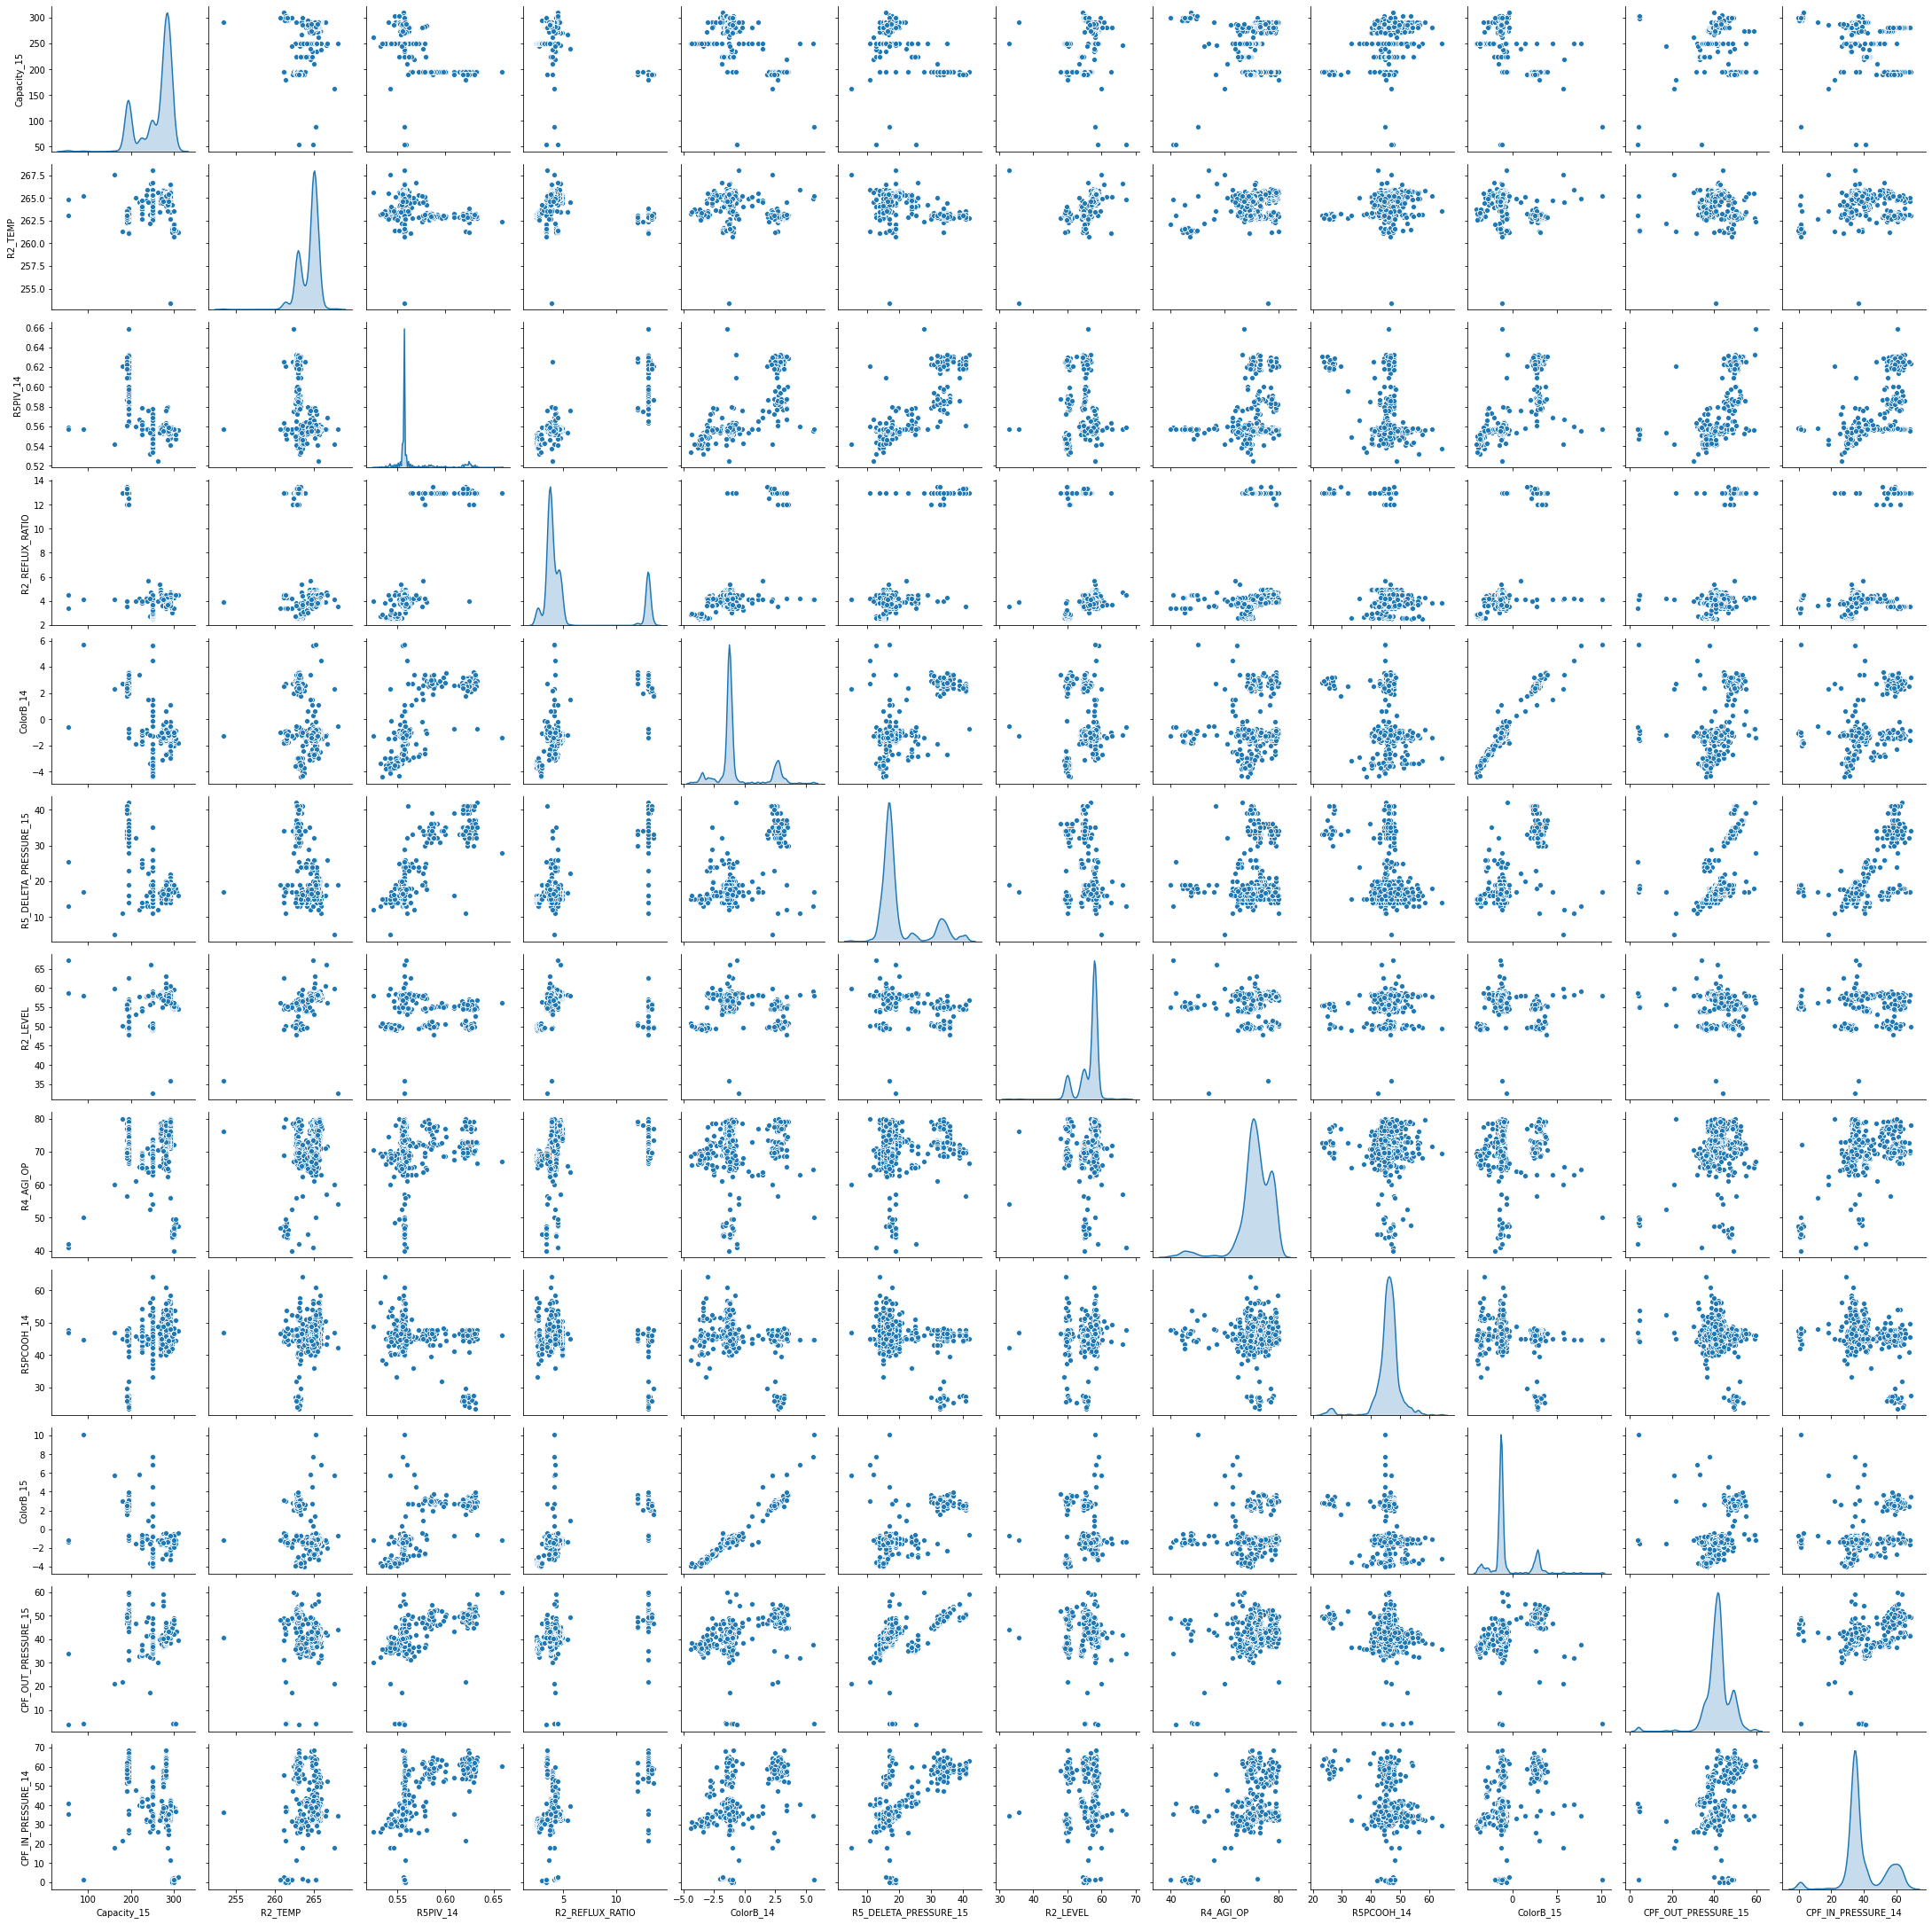

In [30]:
sns.pairplot(train[features], diag_kind = 'kde')

In [5]:
target = 'R1COOH'
train_stats =   train.describe()
train_stats.pop(target)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Capacity_14,676.0,261.100783,37.500181,51.000000,250.000000,282.000000,288.201234,313.000000
R5_AGI_OP_14,676.0,82.096999,13.904246,10.000000,81.000000,85.600000,89.000000,94.500000
R5_AGI_AMP_14,676.0,88.515458,15.069252,0.161249,89.298587,91.476549,93.529522,109.885081
R5_VACCUM_PRESSURE_14,676.0,1.476749,0.754240,0.887459,1.149300,1.331164,1.600241,6.174000
R5_IN_LEVEL_14,676.0,3.001711,1.723758,-2.898597,1.890716,3.214316,4.262094,7.389408
...,...,...,...,...,...,...,...,...
ColorB_15,676.0,-0.629149,1.891948,-4.000000,-1.400000,-1.200000,-1.000000,10.100000
Z_R1_LEVEL_MW,676.0,58433.246893,1812.154332,49534.555000,57793.447500,58451.446500,59433.858250,65788.610000
Z_R1_LEVEL_RT,676.0,168.840594,29.463682,141.546230,149.232067,151.649150,184.758798,445.984200
Z_PASTE_LEVEL_MW,676.0,9056.795607,8633.400574,6794.700000,6794.700000,6794.700000,6794.700000,45641.695000


In [0]:
train_y = train.pop(target)
true_y = test.pop(target)

In [0]:
def norm(x):
  return (x - train_stats['mean'])/train_stats['std']
normed_train_X = norm(train)
normed_test_X = norm(test)

In [0]:
def build_model(p):
  model = Sequential([
    Dense(64, activation='relu', input_shape=[p]),
    Dense(64, activation='relu'),
    Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
import tensorflow as tf
p = normed_train_X.shape[1]
model = build_model(p)

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                9984      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 14,209
Trainable params: 14,209
Non-trainable params: 0
_________________________________________________________________


In [54]:
  print(model.predict(normed_test_X)[:10])

[[ 0.1097607 ]
 [ 0.8845078 ]
 [ 0.06991017]
 [ 0.22743863]
 [ 0.08441705]
 [ 1.7683334 ]
 [ 1.6538005 ]
 [ 0.46582898]
 [ 0.09579155]
 [-1.5199931 ]]


In [11]:
import keras
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print(f'{epoch}\n  ')
    print('.', end='')
EPOCHS = 1000

history = model.fit(
  normed_train_X, train_y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

0
  
....................................................................................................100
  
....................................................................................................200
  
....................................................................................................300
  
....................................................................................................400
  
....................................................................................................500
  
....................................................................................................600
  
....................................................................................................700
  
....................................................................................................800
  
....................................................................................................900
  
................................

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
995,20957.089499,93.102081,20957.087891,121.188401,7.802120,121.188393,995
996,21228.676011,93.255035,21228.675781,118.606831,8.728767,118.606834,996
997,21251.385340,97.473106,21251.386719,109.282849,7.896717,109.282852,997
998,20215.045152,92.814728,20215.046875,111.814177,7.978193,111.814178,998
999,21551.151884,96.760628,21551.150391,120.036924,8.426050,120.036903,999


In [17]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
from tensorflow_docs.plots import HistoryPlotter
plotter = HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

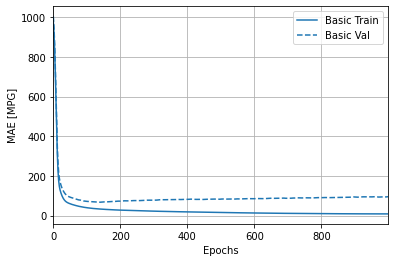

In [19]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

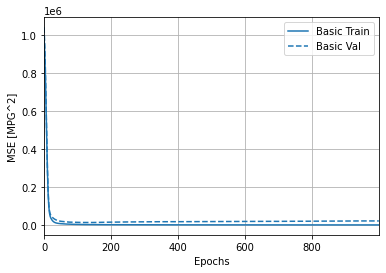

In [20]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE [MPG^2]')

In [24]:
from tensorflow_docs.modeling import EpochDots

model = build_model(p)

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_X, train_y, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, EpochDots()])


Epoch: 0, loss:1153541.1324,  mae:1064.9333,  mse:1153541.0000,  val_loss:1212946.7647,  val_mae:1094.6390,  val_mse:1212946.8750,  
....................................................................................................
Epoch: 100, loss:2696.4331,  mae:38.7722,  mse:2696.4331,  val_loss:13480.2571,  val_mae:73.2851,  val_mse:13480.2578,  
..........

Text(0, 0.5, 'MAE [MPG]')

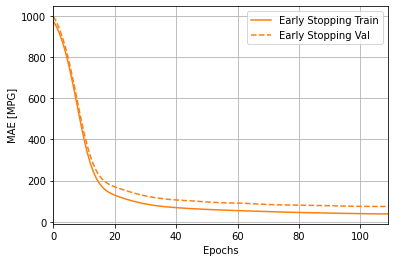

In [25]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylabel('MAE [MPG]')

[]

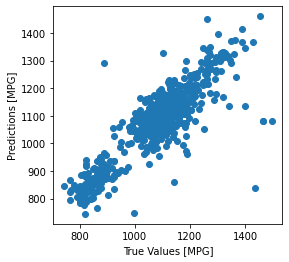

In [27]:
test_predictions = model.predict(normed_test_X).flatten()

a = plt.axes(aspect='equal')
plt.scatter(true_y, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
# lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)
plt.plot()

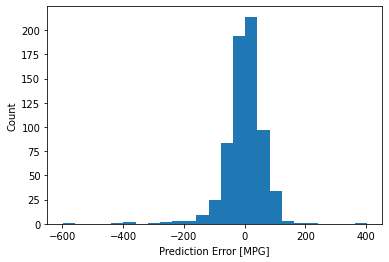

In [28]:
error = test_predictions - true_y
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [29]:
from sklearn.metrics import r2_score

fin_r2 = r2_score(true_y, test_predictions)
print(fin_r2)

0.7522666026302933
